### Import the libraries about model defining

In [1]:
import torch
import torch.nn as nn
import torch.functional as F

### Define Shuffle_V2 Model

In [2]:
def channel_shuffle(x, groups = 2):
    bat_size, channels, w, h = x.shape
    group_c = channels // groups
    x = x.view(bat_size, groups, group_c, w, h)
    x = torch.transpose(x, 1, 2).contiguous()
    x = x.view(bat_size, -1, w, h)
    
    return x

In [3]:
def conv_1x1_bn(in_channels_, out_channels_, stride_ = 1):
    return nn.Sequential(
        nn.Conv2d(in_channels= in_channels_, out_channels= out_channels_, kernel_size= 1, stride= stride_, padding= 0, bias= False),
        nn.BatchNorm2d(out_channels_),
        nn.ReLU6(inplace= True)
    )

In [4]:
class ShuffleBlock(nn.Module):
    def __init__(self, in_channels_, out_channels_, downsample = False):
        super(ShuffleBlock, self).__init__()
        
        self.downsample = downsample
        half_channels_ = out_channels_ //2
        
        if self.downsample:
            self.branch1 = nn.Sequential(
                # 3*3 DW-Conv, stride = 2
                nn.Conv2d(in_channels= in_channels_, out_channels= in_channels_, kernel_size= 3, stride= 2, padding= 1, groups= in_channels_, bias= False),
                nn.BatchNorm2d(in_channels_),
                
                # 1*1 PW-Conv
                nn.Conv2d(in_channels= in_channels_, out_channels= half_channels_, kernel_size= 1, stride= 1, padding= 0, bias= False),
                nn.BatchNorm2d(half_channels_),
                nn.ReLU6(inplace= True)                
            )
            
            self.branch2= nn.Sequential(
                # 1*1 PW-Conv
                nn.Conv2d(in_channels= in_channels_, out_channels= half_channels_, kernel_size= 1, stride= 1, padding= 0, bias= False),
                nn.BatchNorm2d(half_channels_),
                nn.ReLU6(inplace= True),
                
                # 3*3 DW-Conv, stride = 2
                nn.Conv2d(in_channels= half_channels_, out_channels= half_channels_, kernel_size= 3, stride= 2, padding= 1, groups= half_channels_, bias= False),
                nn.BatchNorm2d(half_channels_),
                
                # 1*1 PW-Conv
                nn.Conv2d(in_channels= half_channels_, out_channels= half_channels_, kernel_size= 1, stride= 1, padding= 0, bias= False),
                nn.BatchNorm2d(half_channels_),
                nn.ReLU6(inplace= True)                
            )
            
        else:
            assert in_channels_  == out_channels_
            
            self.branch2 = nn.Sequential(
                
                # 1*1 pw conv
                nn.Conv2d(in_channels= half_channels_, out_channels= half_channels_, kernel_size= 1, stride= 1, padding= 0, bias= False),
                nn.BatchNorm2d(half_channels_),
                nn.ReLU(inplace= True),
                
                # 3*3 dw conv, stride = 1
                nn.Conv2d(in_channels= half_channels_, out_channels= half_channels_, kernel_size= 3, stride= 1, padding= 1, groups= half_channels_, bias= False),
                nn.BatchNorm2d(half_channels_),
                
                # 1*1 pw conv
                nn.Conv2d(in_channels= half_channels_, out_channels= half_channels_, kernel_size= 1, stride= 1, padding= 0, bias= False),
                nn.BatchNorm2d(half_channels_),
                nn.ReLU6(inplace= True)              
            )
        
    def forward(self, x):
        out = None
        if self.downsample:
            out = torch.cat((self.branch1(x), self.branch2(x)), 1)

        else:
            channels = x.shape[1]
            c = channels // 2
            x1 = x[:, :c, :, :]
            x2 = x[:, c:, :, :]
            out = torch.cat((x1, self.branch2(x2)), 1)
        return channel_shuffle(out, 2)
                        

In [5]:
class ShuffleNetV2(nn.Module):
    def __init__(self, num_classes= 2, input_size= 224, net_type= 1):
        super(ShuffleNetV2, self).__init__()
        assert input_size % 32 == 0
        
        self.stage_repeat_num = [4, 8, 4]
        if net_type == 0.5:
            self.out_channels = [3, 24, 48,  96,  192, 1024]
        elif net_type == 1:
            self.out_channels = [3, 24, 116, 232, 464, 1024]
        elif net_type == 1.5:
            self.out_channels = [3, 24, 176, 352, 704, 1024]
        elif net_type == 2:
            self.out_channels = [3, 24, 244, 488, 976, 2948]
        else:
            print("the type is error")
            
        self.conv1 = nn.Conv2d(in_channels= 3, out_channels= self.out_channels[1], kernel_size= 3, stride= 2, padding= 1)
        self.maxpool = nn.MaxPool2d(kernel_size= 3, stride= 2, padding= 1)
    
        in_c = self.out_channels[1]    
        self.stages = []
    
        for stage_idx in range(len(self.stage_repeat_num)):
            out_c = self.out_channels[2 + stage_idx]
            repeat_num = self.stage_repeat_num[stage_idx]

            for i in range(repeat_num):
                if i == 0:
                    self.stages.append(ShuffleBlock(in_c, out_c, downsample = True))
                else:
                    self.stages.append(ShuffleBlock(in_c, out_c, downsample = False))
                in_c = out_c

        self.stages = nn.Sequential(*self.stages)

        in_c = self.out_channels[-2]
        out_c = self.out_channels[-1]

        self.conv5 = conv_1x1_bn(in_c, out_c, 1)
        self.g_avg_pool = nn.AvgPool2d(kernel_size = (int)(input_size/32))
        #self.g_avg_pool = nn.AdaptiveAvgPool2d(1)

        self.fc = nn.Linear(in_features= out_c, out_features= num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.stages(x)
        x = self.conv5(x)
        x = self.g_avg_pool(x)
        x = x.view(-1, self.out_channels[-1])
        x = self.fc(x)
        return x       

### Check for GPU availablity

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

print(torch.cuda.is_available())
model = ShuffleNetV2()
model = model.to(device)

cuda
True


### Show Model Summary

In [7]:
from torchsummary import summary
model = ShuffleNetV2()
summary(model.cuda(), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 112, 112]             672
         MaxPool2d-2           [-1, 24, 56, 56]               0
            Conv2d-3           [-1, 24, 28, 28]             216
       BatchNorm2d-4           [-1, 24, 28, 28]              48
            Conv2d-5           [-1, 58, 28, 28]           1,392
       BatchNorm2d-6           [-1, 58, 28, 28]             116
             ReLU6-7           [-1, 58, 28, 28]               0
            Conv2d-8           [-1, 58, 56, 56]           1,392
       BatchNorm2d-9           [-1, 58, 56, 56]             116
            ReLU6-10           [-1, 58, 56, 56]               0
           Conv2d-11           [-1, 58, 28, 28]             522
      BatchNorm2d-12           [-1, 58, 28, 28]             116
           Conv2d-13           [-1, 58, 28, 28]           3,364
      BatchNorm2d-14           [-1, 58,

### Import the libraries about data preprocess

In [8]:
from torchvision import datasets, transforms
from torch.utils import data

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from glob import glob
import os
import time
import copy

from tqdm.notebook import tqdm

### Define Class - for retirving images and lables

In [9]:
class DogCat(data.Dataset):
    def __init__(self, root= "DogCatDataSet/train", trans= None, train= True):
        
        self.train = train  
     
        imgs = [os.path.join(root, img) for img in os.listdir(root)]    
        sorted(imgs, key= lambda x : int(x.split(".")[-2]))  #/DogCatDataSet/train\\cat.0.jpg

        np.random.seed(100)
        imgs = np.random.permutation(imgs)

        if train:
            self.imgs = imgs[ :int(0.7 * len(imgs))]
        else:
            self.imgs = imgs[int(0.7 * len(imgs)): ]


        if trans == None:
            self.trans = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean= [ 0.485, 0.456, 0.406],             
                                     std = [ 0.229, 0.224, 0.225] )
            ])
                
                
    def __getitem__(self, index):
        imgpath = self.imgs[index]
        img = Image.open(imgpath)
        img = self.trans(img)
        
        kind = imgpath.split(".")[-3].split("\\")[-1]   #/DogCatDataSet/train\\cat.0.jpg
        label = 1 if kind == "dog" else 0
        
        return img, label
    
    def __len__(self):
        return len(self.imgs)
    

In [10]:
def DogCat_test(path = "DogCatDataSet/test", trans = None):
    
    if trans:        
        test_trans = trans
    
    elif trans == None:   
        test_trans = transforms.Compose([
                            transforms.Resize(224),
                            transforms.CenterCrop(224),
                            transforms.ToTensor(),
                            transforms.Normalize(mean= [ 0.485, 0.456, 0.406],
                                                 std = [ 0.229, 0.224, 0.225] )
                        ])
    
    test_dataset = datasets.ImageFolder(path, transform = test_trans)
    
    return test_dataset

### Prepare dataset for training model

In [15]:
train_dataset = DogCat("DogCatDataSet/train", train = True)
val_dataset   = DogCat("DogCatDataSet/train", train = False)
test_dataset  = DogCat_test("DogCatDataSet/test")

train_loader = data.DataLoader(train_dataset, batch_size = 32, shuffle = True)
val_loader   = data.DataLoader(val_dataset,   batch_size = 32, shuffle = True)
test_loader = data.DataLoader(test_dataset,  batch_size = 32, shuffle = True)

#train_loader = data.DataLoader(train_dataset, batch_size = 32, shuffle = True, num_workers= 4)
#val_loader   = data.DataLoader(val_dataset,   batch_size = 32, shuffle = True, num_workers= 4)
#test_loader = data.DataLoader(test_dataset,   batch_size = 32, shuffle = True, num_workers= 4)

dataloader = {}
dataloader["train"] = train_loader
dataloader["valid"] = val_loader

In [16]:
dataiter = iter(train_loader)
images_train, labels_train = dataiter.next()
print(f"train dataset shape, images: {images_train.shape}   labels: {labels_train.shape}")

dataiter = iter(val_loader)
images_val, labels_val = dataiter.next()
print(f"valid dataset shape, images: {images_val.shape}   labels: {labels_val.shape}")

dataiter = iter(test_loader)
images_test, labels_test = dataiter.next()
print(f"test dataset shape, images: {images_test.shape}   labels: {labels_test.shape}")

train dataset shape, images: torch.Size([32, 3, 224, 224])   labels: torch.Size([32])
valid dataset shape, images: torch.Size([32, 3, 224, 224])   labels: torch.Size([32])
test dataset shape, images: torch.Size([32, 3, 224, 224])   labels: torch.Size([32])


### Define the function to show the images of the dataset via denormalize

In [17]:
classes = ["cat", "dog"]
mean , std = torch.tensor([0.485, 0.456, 0.406]), torch.tensor([0.229, 0.224, 0.225])

def denormalize(images):
    image = transforms.Normalize( -mean/std, 1/std)(images)
    image = image.permute(1, 2, 0)  #changing from (3 x 224 x 224) to (224 x 224 x 3)
    image = torch.clamp(image, 0, 1)
    return image

def imshow(img):
    img = denormalize(img)
    plt.imshow(img)
    
def visual_dataset(loader):
    dataiter = iter(loader)
    images, labels = dataiter.next()

    fig = plt.figure(figsize=(25, 8))
    for idx in np.arange(20):
        ax = fig.add_subplot(2 , 20/2, idx+1, xticks= [], yticks= [])
        imshow(images[idx])
        ax.set_title(f"{classes[labels[idx]]}")

D:\Anoconda\envs\cv\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


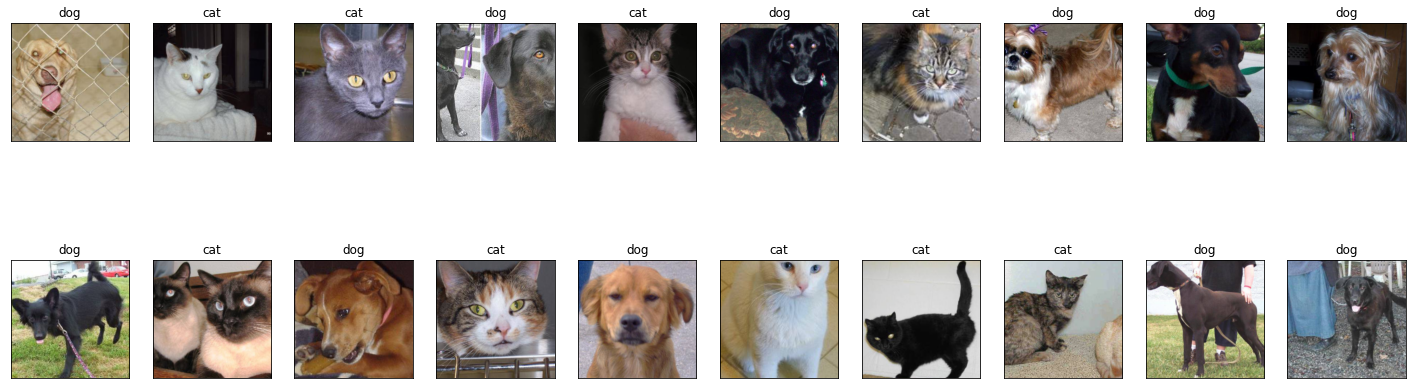

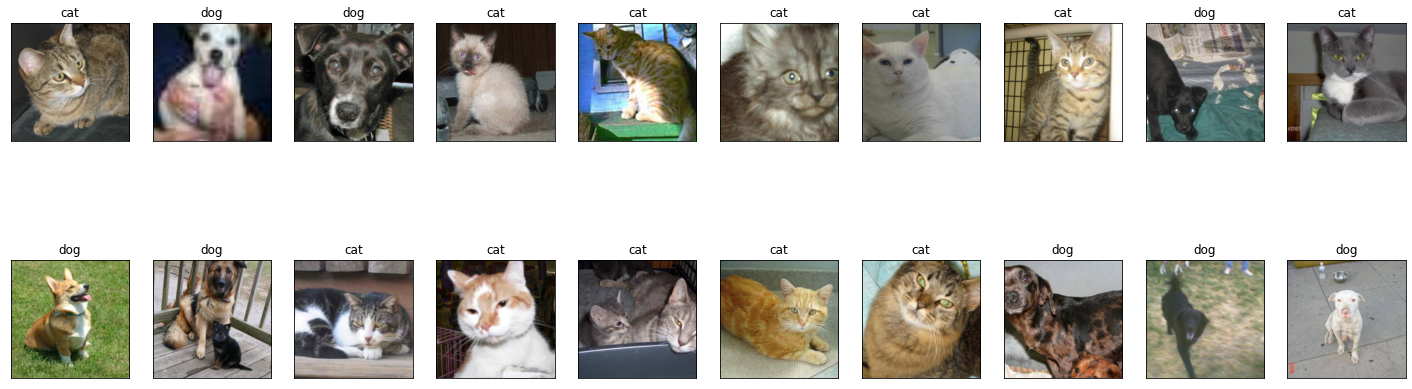

In [18]:
visual_dataset(train_loader)
visual_dataset(test_loader)

### Define model parameters like optimizer, learning rate, , loss function, epochs

In [19]:
Epoch = 100
learning_rate = 0.01

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr= learning_rate, momentum= 0.9)

train_logs = {"epoch": [], "loss": [], "accuracy": [], "time": []}
val_logs   = {"epoch": [], "loss": [], "accuracy": [], "time": []}

### Define a fucntion to save model and weights

In [20]:
def save_model(model, path, weight= None, verbose= True):
    
    if weight:
        state_dict = weight
    else:
        state_dict = model.state_dict()
       
    checkpoint = {
        'parameters': model.parameters,
        'state_dict': state_dict
    }
    
    if verbose:
        print("Checkpoint created..")
        
    torch.save(checkpoint, path)
    
    if verbose:
        print("Checkpoint saved..")

### Define a function to train model

In [21]:
def training_model(model, dataloaders, loss_fn, optimizer, num_epoch):
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0
   
    for epoch in range(num_epoch):
        print("=================================================================================================")
        print(f"Epoch: {epoch+1}/{num_epoch}")
        
        for phase in ["train", "valid"]:           
            running_loss = 0
            running_corrects = 0
                      
            if phase == "train":
                model.train()
            else:
                model.eval()
            
            #============================================================================#
            start_time = time.time()
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs, labels = inputs.to(device), labels.to(device)

                with torch.autograd.set_grad_enabled(phase=="train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                
                preds = outputs.argmax(dim = 1)
                if phase == "train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds.view(-1) == labels.view(-1)).item() 
                
            end_time = time.time()
            #============================================================================#
                            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            total_time = end_time - start_time
                            
            if phase == "valid" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
                 
            if phase == "train":
                train_logs["epoch"].append(epoch)
                train_logs["loss"].append(epoch_loss)
                train_logs["accuracy"].append(epoch_acc)
                train_logs["time"].append(total_time)   
                
            elif phase == "valid":
                val_logs["epoch"].append(epoch)
                val_logs["loss"].append(epoch_loss)
                val_logs["accuracy"].append(epoch_acc)
                val_logs["time"].append(total_time)                 
                if epoch % 100 == 0:                             
                    savePath = "checkpoint/epoch" + "{:05}".format(epoch)   #checkpoint/epoch100.pth
                    save_model(model, savePath + ".pth", weight= best_model_wts)
                                
            print(f"{phase.title()}   Loss: {epoch_loss}   Acc: {epoch_acc}   Time: {total_time}")
      
    savePath = "checkpoint/lastWeight"   #checkpoint/epoch100.pth
    save_model(model, best_model_wts, savePath + ".pth", weight= best_model_wts)
    model.load_state_dict(best_model_wts)
    
    return model, best_model_wts                                

### Training Model

In [ ]:
model, best_model_wts = training_model(model, dataloader, criterion, optimizer, Epoch)

Epoch: 1/100


  0%|          | 0/547 [00:00<?, ?it/s]

Checkpoint created..
Checkpoint saved..
Train   Loss: 0.6850773471423558   Acc: 0.6065714285714285   Time: 275.7820899486542


D:\Anoconda\envs\cv\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type ShuffleNetV2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
D:\Anoconda\envs\cv\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type ShuffleBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


  0%|          | 0/235 [00:00<?, ?it/s]

Checkpoint created..
Checkpoint saved..
Valid   Loss: 0.5994753872553508   Acc: 0.6854666666666667   Time: 108.9042181968689
Epoch: 2/100


  0%|          | 0/547 [00:00<?, ?it/s]

Train   Loss: 0.6090079772063665   Acc: 0.6973714285714285   Time: 194.95635199546814


  0%|          | 0/235 [00:00<?, ?it/s]

Valid   Loss: 0.5205028674443563   Acc: 0.7498666666666667   Time: 57.59398078918457
Epoch: 3/100


  0%|          | 0/547 [00:00<?, ?it/s]

Train   Loss: 0.4916494634219578   Acc: 0.7682857142857142   Time: 194.2198097705841


  0%|          | 0/235 [00:00<?, ?it/s]

Valid   Loss: 0.44193625871340436   Acc: 0.8058666666666666   Time: 56.20094537734985
Epoch: 4/100


  0%|          | 0/547 [00:00<?, ?it/s]

Train   Loss: 0.44747045215879167   Acc: 0.7989142857142857   Time: 186.74100303649902


  0%|          | 0/235 [00:00<?, ?it/s]

Valid   Loss: 0.4310756187438965   Acc: 0.8030666666666667   Time: 51.863099575042725
Epoch: 5/100


  0%|          | 0/547 [00:00<?, ?it/s]

Train   Loss: 0.3871959371498653   Acc: 0.8280571428571428   Time: 176.56220769882202


  0%|          | 0/235 [00:00<?, ?it/s]

Valid   Loss: 0.37637629515329996   Acc: 0.8354666666666667   Time: 49.67648410797119
Epoch: 6/100


  0%|          | 0/547 [00:00<?, ?it/s]

Train   Loss: 0.3553700408765248   Acc: 0.8458285714285714   Time: 175.16085076332092


  0%|          | 0/235 [00:00<?, ?it/s]

Valid   Loss: 0.4031952506860097   Acc: 0.8258666666666666   Time: 50.174540996551514
Epoch: 7/100


  0%|          | 0/547 [00:00<?, ?it/s]

Train   Loss: 0.32391512788363863   Acc: 0.8608   Time: 176.33028507232666


  0%|          | 0/235 [00:00<?, ?it/s]

Valid   Loss: 0.3360657723903656   Acc: 0.8546666666666667   Time: 56.77131795883179
Epoch: 8/100


  0%|          | 0/547 [00:00<?, ?it/s]

### Ploting The Accuracies and Losses

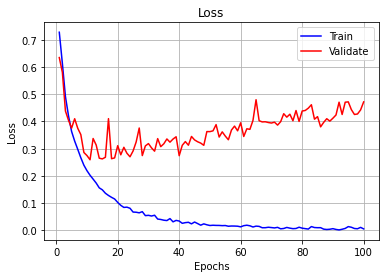

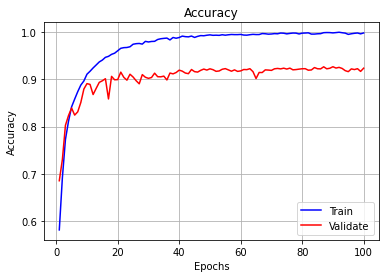

In [18]:
#Loss
plt.title("Loss")
plt.plot(np.arange(1, Epoch+1, 1), train_logs["loss"], color = 'blue', label = "Train")
plt.plot(np.arange(1, Epoch+1, 1), val_logs["loss"], color = 'red', label = "Validate")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

#Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, Epoch+1, 1), train_logs["accuracy"], color = 'blue', label = "Train")
plt.plot(np.arange(1, Epoch+1, 1), val_logs["accuracy"], color = 'red', label = "Validate")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.show()

In [24]:
def load_model(path, cuda = True):
    try:
        if cuda:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            device = torch.device("cpu")
        
        checkpoint = torch.load(path, map_location= device )
        
    except Exception as err:
        print(err)
        return None
    
    model = ShuffleNetV2()
    
    model.parameters = checkpoint["parameters"]
    model.load_state_dict(checkpoint["state_dict"])
    
    return model

In [25]:
path = "checkpoint/epoch100.pth"
new_model = load_model(path)

### Define a function to test model

In [30]:
def test_model(model, dataloader, criterion):
    model.eval()
    running_loss = 0.
    running_corrects = 0.
    fps_records = []
    
    for inputs, labels in tqdm(dataloader):
        img_len = len(inputs)
        inputs, labels = inputs.to(device), labels.to(device)
        
        #======================================================#
        start = time.time()
        outputs = model(inputs)
        end = time.time()
        #======================================================#
        
        fps = img_len/(end-start)
        fps_records.append(fps)
        loss = criterion(outputs, labels) 
        preds = outputs.argmax(dim= 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds.view(-1) == labels.view(-1)).item()
  
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects / len(dataloader.dataset)
    epoch_fps = np.mean(fps_records)

    print("On Val Dataset Loss: {}, Acc: {}, FPS: {}".format(epoch_loss, epoch_acc, epoch_fps))

### Testing Model

In [32]:
test_model(model, test_loader, criterion)

  0%|          | 0/40 [00:00<?, ?it/s]

On Val Dataset Loss: 0.6932035589975024, Acc: 0.5, FPS: 730.3623137008611
